In [2]:
import matplotlib
matplotlib.use('Agg')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import sys
sys.path.insert(0,'../../')
from helpers import *
from scipy.sparse import csr_matrix,save_npz,load_npz
from sklearn.model_selection import cross_val_score,LeaveOneOut,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
import pickle
from sklearn.pipeline import Pipeline
# Algorithms
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,ElasticNetCV,ElasticNet
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
import lightgbm as lgb

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
train = pd.read_pickle('../data/feature_engineering/sub_train_freq.pkl')
test = pd.read_pickle('../data/feature_engineering/sub_test_freq.pkl')

In [4]:
train_X = train.drop(['sample_name','phenotype_status'],axis=1).values
test_X = test.drop(['sample_name','phenotype_status'],axis=1).values
# train_X = train[kept_TCRs].values
# test_X = test[kept_TCRs].values
train_y = train['phenotype_status'].values
test_y = test['phenotype_status'].values

In [6]:
train_X.shape

(641, 165)

In [5]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

Optimal number of features : 163
AUROC: 0.9502699630576869 Accuracy:  0.9
Best_score: 0.9736636953632027


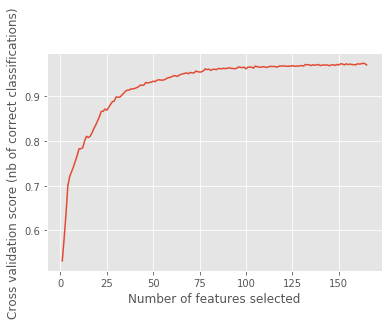

In [6]:
rfecv = RFECV(rf,cv=StratifiedKFold(10,random_state=0),scoring='roc_auc',step = 1)
rfecv.fit(train_X,train['phenotype_status'])

print("Optimal number of features : %d" % rfecv.n_features_)

print('AUROC:',roc_auc_score(test['phenotype_status'],rfecv.predict_proba(test_X)[:,1]),'Accuracy: ',accuracy_score(test['phenotype_status'],
        rfecv.predict(test_X)))
print('Best_score:',max(rfecv.grid_scores_))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [10]:
TCRs = train.drop(['sample_name','phenotype_status'],axis=1).columns
rfe_feature = train[TCRs].loc[:,rfecv.get_support()].columns.tolist()

In [14]:
sub_train_X = train[rfe_feature]
sub_test_X = test[rfe_feature]

In [19]:
cross_val_score(rf,sub_train_X.values,train_y, cv=10, scoring='roc_auc')

array([0.97988506, 0.92624521, 0.98325123, 0.9773399 , 0.99310345,
       0.98128079, 0.99704433, 0.98029557, 0.97044335, 0.94081633])

In [20]:
def LOOCV_AUROC(clf,X,y):
    y_true = []
    y_proba = []
    kf = LeaveOneOut()
    for train_index,test_index in kf.split(X): # for each cv round
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train,y_train)
        pred_proba = clf.predict_proba(X_test)[:,1][0]
        y_true.append(y_test[0])
        y_proba.append(pred_proba)
    auroc = roc_auc_score(y_true,y_proba)
    print('AUROC:',auroc)
    return auroc

In [22]:
LOOCV_AUROC(rf,sub_train_X.values,train_y)

[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 

0.9737535388486946

In [1]:
def LOOCV_AUROC(clf,X,y):
    y_true = []
    y_proba = []
    kf = LeaveOneOut()
    for train_index,test_index in kf.split(X): # for each cv round
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train,y_train)
        pred_proba = clf.predict_proba(X_test)[:,1][0]
        y_true.append(y_test[0])
        y_proba.append(pred_proba)
    auroc = roc_auc_score(y_true,y_proba)
    print('AUROC:',auroc)
    return auroc

In [24]:
rf.fit(sub_train_X.values,train_y)
pred_proba = rf.predict_proba(sub_test_X)[:,1]
roc_auc_score(test_y,pred_proba)

0.9502699630576869

In [26]:
lr = LogisticRegression()

In [27]:
pipeline = Pipeline([
    ('fs', SelectFromModel(rf)),
    ('estimator', lr),
])
params = {
    'fs__threshold': ['0.2*mean','0.25*mean','0.3*mean','0.4*mean','median'],
    'estimator__C': [0.5,1,5,10],
#     'clf__max_features': ['auto', 'sqrt', 'log2'],
 }
cv_pipeline = GridSearchCV(estimator=pipeline, param_grid=params)
cv_pipeline.fit(X=sub_train_X, y=train_y)
final_pipeline = cv_pipeline.best_estimator_
final_classifier = final_pipeline.named_steps['estimator']

In [28]:
final_classifier

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
PRED = cv_pipeline.predict_proba(sub_test_X)
roc_auc_score(test_y,pred_proba)

0.9502699630576869

In [31]:
sub_train_X['sum'] = sub_train_X.apply(np.sum,axis=1)

In [33]:
sub_test_X['sum'] = sub_test_X.apply(np.sum,axis=1)

In [34]:
rf.fit(sub_train_X.values,train_y)
pred_proba = rf.predict_proba(sub_test_X)[:,1]
roc_auc_score(test_y,pred_proba)

0.9494174481386758